# Imports

## Packages

In [238]:
import zipfile
import os

In [239]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy import stats

## Data

In [240]:
zip_path = "Apple Stock Prices From 1981 to 2023.zip"
extract_dir = "unzipped_files"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Files extracted to: {extract_dir}")

Files extracted to: unzipped_files


In [241]:

df = pd.read_csv("unzipped_files/Apple Stock Prices (1981 to 2023).csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1981,0.154018,0.155134,0.154018,0.154018,0.119849,21660800
1,05/01/1981,0.151228,0.151228,0.150670,0.150670,0.117244,35728000
2,06/01/1981,0.144531,0.144531,0.143973,0.143973,0.112032,45158400
3,07/01/1981,0.138393,0.138393,0.137835,0.137835,0.107256,55686400
4,08/01/1981,0.135603,0.135603,0.135045,0.135045,0.105085,39827200


# EDA

## Basic Description

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10608 entries, 0 to 10607
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10608 non-null  object 
 1   Open       10608 non-null  float64
 2   High       10608 non-null  float64
 3   Low        10608 non-null  float64
 4   Close      10608 non-null  float64
 5   Adj Close  10608 non-null  float64
 6   Volume     10608 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 580.3+ KB


In [243]:
print("Duplicate rows:", df.duplicated().sum()) # Check for duplicates
print("\nMissing values per column:")
print(df.isnull().sum()) #handle missing values

Duplicate rows: 0

Missing values per column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [244]:
print("First date:", df["Date"].min().date())
print("Last date :", df["Date"].max().date())
print("Row count :", len(df))
print("Unique dates:", df["Date"].nunique())
print("Has duplicate dates?", df["Date"].nunique() < len(df))

AttributeError: 'str' object has no attribute 'date'

## Convert date columns to datetime

In [ ]:
date_column = ['Date']
df['Date'] = pd.to_datetime(df['Date'],format ="%d/%m/%Y", errors ="coerce")
print("Data types after conversion:")
print(df['Date'].dtypes)



Data types after conversion:
datetime64[ns]


## Time Series Properties

### Initial Plot

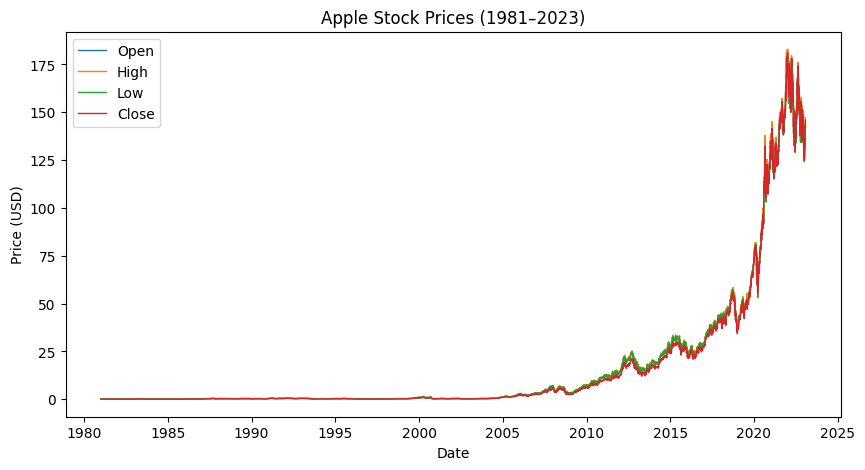

In [ ]:
# Plot Open, High, Low, Close
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Open"], label="Open", linewidth=1)
plt.plot(df["Date"], df["High"], label="High", linewidth=1)
plt.plot(df["Date"], df["Low"], label="Low", linewidth=1)
plt.plot(df["Date"], df["Adj Close"], label="Close", linewidth=1)

plt.title("Apple Stock Prices (1981–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


The values are too close to each other to see the difference. Let's focus on the adj. close and visualize the trend

### Trend

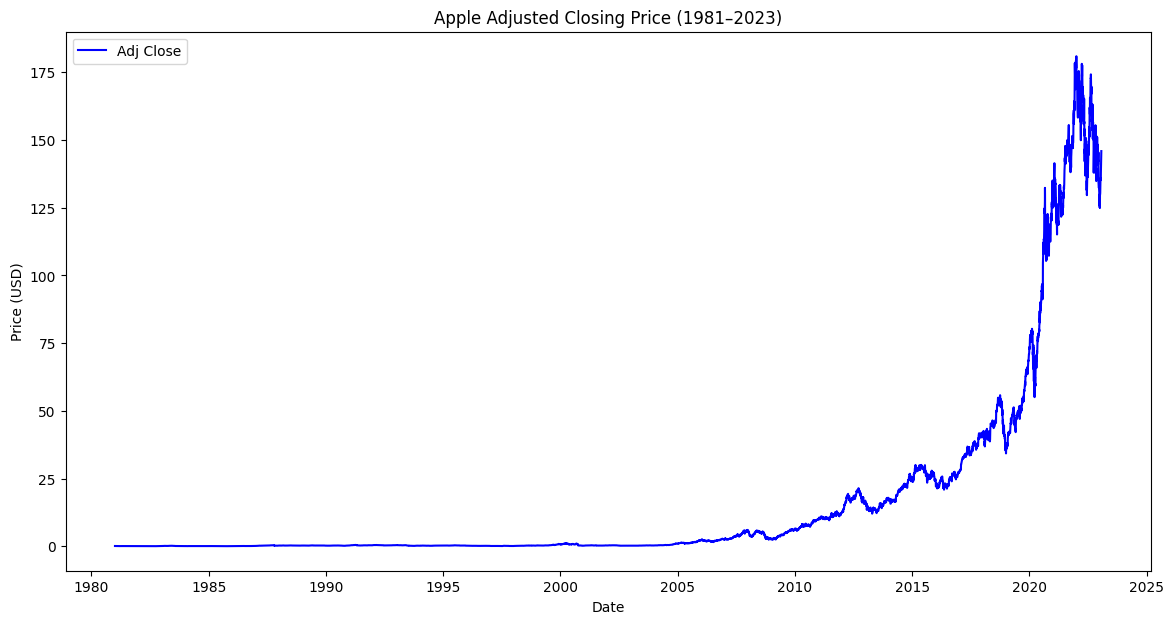

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(df["Date"], df["Adj Close"], label="Adj Close", color="blue")
plt.title("Apple Adjusted Closing Price (1981–2023)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


We observe 3 main phases during the whole period:
- <b>1980 - 2000:</b> Little to no increse in stock prices
- <b>2000 - 2008:</b> Small stock's price growth (Steve Jobs joins back, release the first ipod, but 2008 subprime crisis)
- <b>2008 - 2019:</b> Exponential increase in stock prices (release of first iphone, solid market loyalty...)
- <b>2019 - 2021:</b> Huge spike in stocks( COVID-19 demand for electronics)
- <b>2022 - 2023:</b> Sharp decline in stock prices (global supply chain crisis)

### Frequency

#### Naive Frequency

In [ ]:
ts = df.set_index("Date", drop=False).sort_index()
print("Inferred freq:", pd.infer_freq(ts.index))


Inferred freq: None


### Weekday Frequency

In [ ]:

deltas = ts.index.to_series().diff().dropna()
print("\nMost common step (mode):", deltas.mode().iloc[0])
print("Median step             :", deltas.median())
print("Share of 1 business-day steps:",
      (deltas == pd.Timedelta(days=1)).mean().round(3),
      " (note: calendar days, not trading)")



Most common step (mode): 1 days 00:00:00
Median step             : 1 days 00:00:00
Share of 1 business-day steps: 0.784  (note: calendar days, not trading)


Most of the dates (78.4%) in the dataset are 1 calendar day apart (21.6 % are weekends and holidays).This is a normal pattern for stock market data. Let's verify it

In [ ]:
bidx = pd.bdate_range(start=ts.index.min(), end=ts.index.max(), freq="D")
aligned = ts.reindex(bidx)
missing_mask = aligned.index.difference(ts.index)
print("\nApprox. missing days count:", len(missing_mask))



Approx. missing business days count: 4758


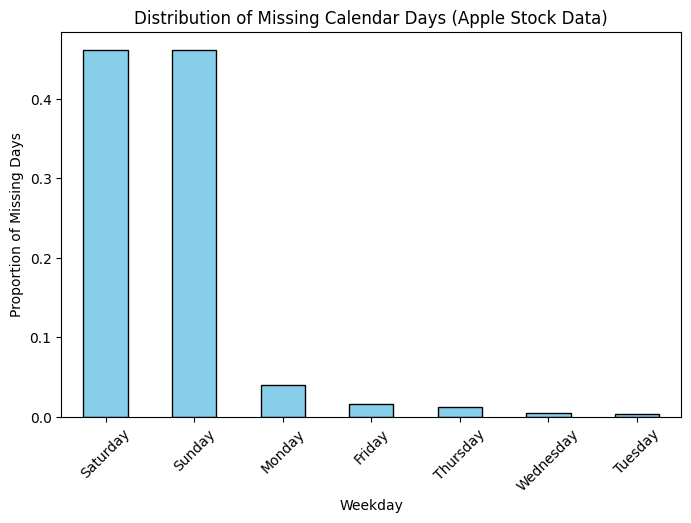

In [ ]:

missing_weekdays = missing_mask.day_name()

weekday_counts = missing_weekdays.value_counts(normalize=True)

# Plot
plt.figure(figsize=(8,5))
weekday_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Distribution of Missing Calendar Days (Apple Stock Data)")
plt.ylabel("Proportion of Missing Days")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.show()


We confirmed that the missing days are indeed weekends and the other ones must be holidays.

### Yearly trading days frequency

In [ ]:
by_year_counts = ts.resample("YE").size()
print("\nObserved trading days per year:")
print(by_year_counts.tail(10))


Observed trading days per year:
Date
2014-12-31    252
2015-12-31    252
2016-12-31    252
2017-12-31    251
2018-12-31    251
2019-12-31    252
2020-12-31    253
2021-12-31    252
2022-12-31    251
2023-12-31     18
Freq: YE-DEC, dtype: int64


We can observe that each year has approx 252 trading days except 2023 due to the data ending on 2023-01-27.It must represent 18 trading days.

### Daily Returns

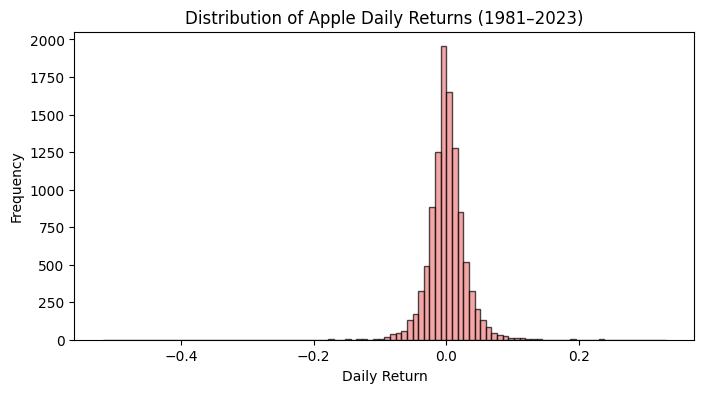

Min daily return: -0.52
Max daily return: 0.33


In [ ]:
df["Daily Return"] = df["Adj Close"].pct_change()
plt.figure(figsize=(8,4))
plt.hist(df["Daily Return"].dropna(), bins=100, color="lightcoral", edgecolor="black", alpha=0.7)

plt.title("Distribution of Apple Daily Returns (1981–2023)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


print("Min daily return:", df["Daily Return"].min().round(2))
print("Max daily return:", df["Daily Return"].max().round(2))


- The distribution of data is centered around 0 -> most of the days Apple's stock barely moves up or down.
- It typically moves within -2% / +2% per day.
- Rare we can observe some significant outliers (e.g min or max daily return)

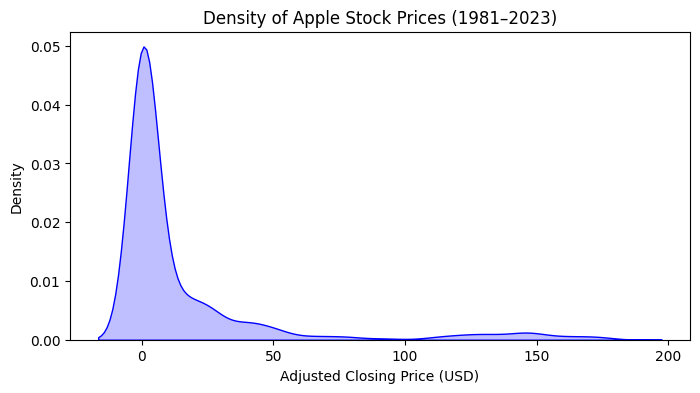

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.kdeplot(df["Adj Close"], fill=True, color="blue")

plt.title("Density of Apple Stock Prices (1981–2023)")
plt.xlabel("Adjusted Closing Price (USD)")
plt.ylabel("Density")
plt.show()


Plot shows that Apple’s stock has historically spent most of its life at low valuations, with the very high prices being a more recent phenomenon.

# Data Visualization

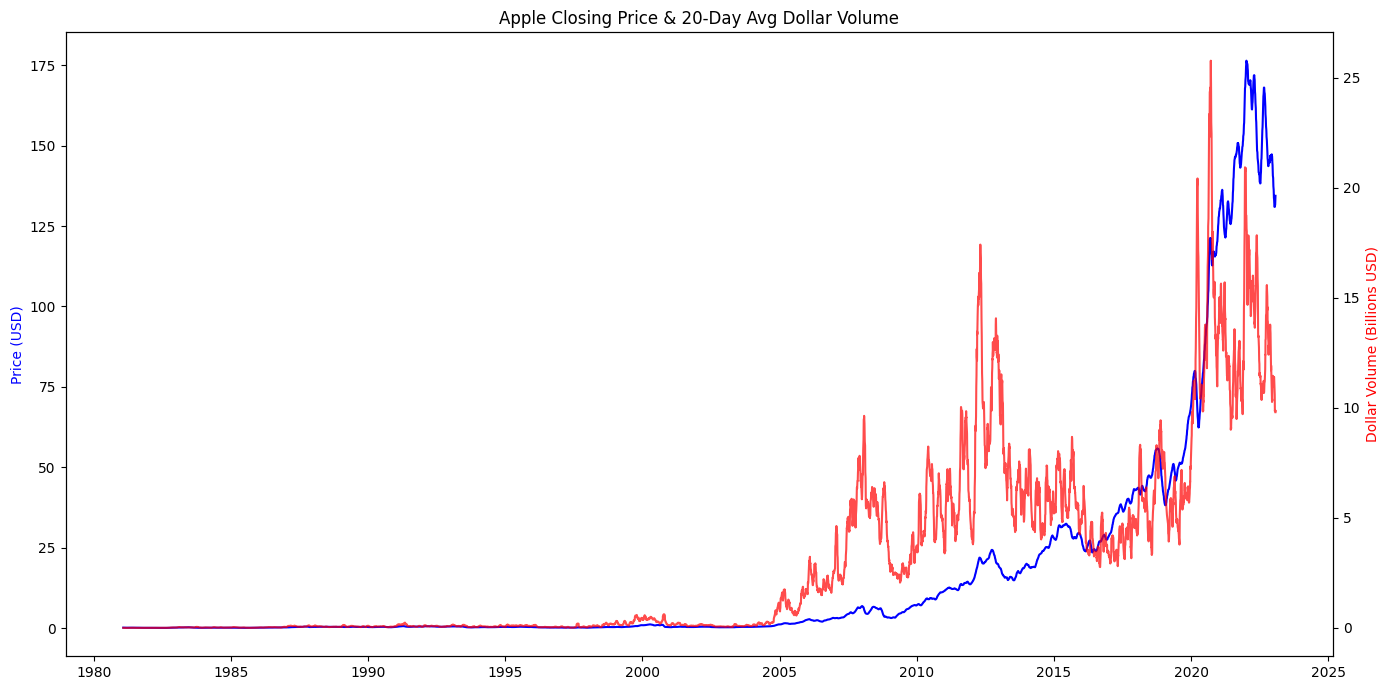

In [ ]:
# 20-day rolling averages
df["Close_20D"] = df["Close"].rolling(20).mean()
df["DollarVolume_20D"] = (df["Close"] * df["Volume"]).rolling(20).mean()


fig, ax1 = plt.subplots(figsize=(14,7))

# Plot smoothed closing price
ax1.plot(df["Date"], df["Close_20D"], color="blue", label="20D Close (USD)")
ax1.set_ylabel("Price (USD)", color="blue")

# Plot smoothed dollar volume (billions)
ax2 = ax1.twinx()
ax2.plot(df["Date"], df["DollarVolume_20D"]/1e9, color="red", alpha=0.7, label="20D Dollar Volume")
ax2.set_ylabel("Dollar Volume (Billions USD)", color="red")

plt.title("Apple Closing Price & 20-Day Avg Dollar Volume")
fig.tight_layout()

plt.show()


- Apple’s closing price stayed relatively flat until the mid-2000s, after which it grew dramatically (release of ipod,iphone)
- Dollar trading volume increased significantly over time showing rising investor interest
- Spikes in dolar volume corresponds to major events: Financial crisis (2008), prduct launchea and COVID-19
- Between 2018-2022 both price and dollar volume reached records highs -> Apple transformed to one of the most traded and valuable companies.

### Candlestick charts

### Daily - Last 6 months

/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_59908/61213500.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  mpf.plot(dfc.last('180D'), type='candle', volume=True, style='yahoo',


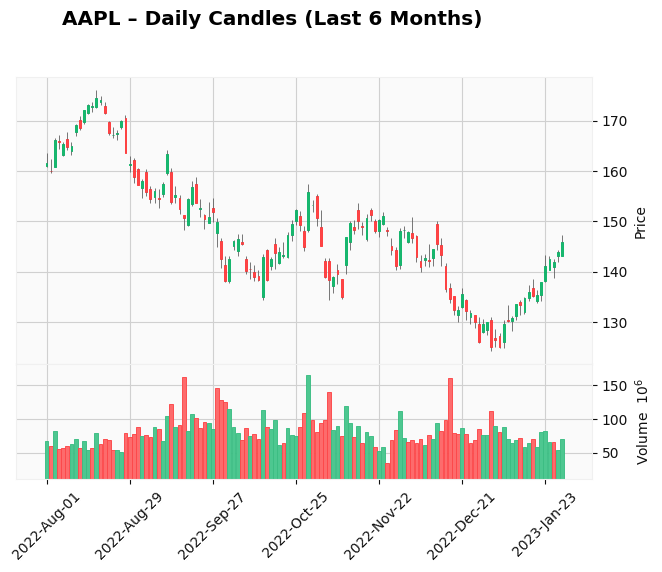

In [ ]:
import mplfinance as mpf
dfc = df.set_index(pd.to_datetime(df['Date'])).sort_index()
mpf.plot(dfc.last('180D'), type='candle', volume=True, style='yahoo',
         title='AAPL – Daily Candles (Last 6 Months)')


- Overall trend: Apple’s stock declined from around $170 in August 2022 to a low near $125 in December 2022, before rebounding into early 2023 (~$145).

### Monthly (2015 - Present)

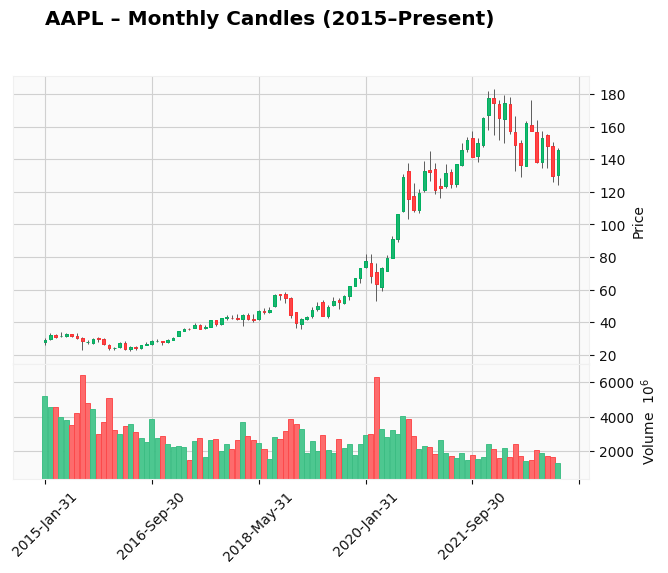

In [ ]:
mo = dfc.resample('ME').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
mpf.plot(mo.loc['2015':], type='candle', volume=True, style='yahoo',
         title='AAPL – Monthly Candles (2015–Present)')


- 2015–2018: Apple traded relatively flat, mostly between $20–$60. Growth was steady but not explosive.

- 2019–2020: Beginning of a strong uptrend. Prices broke above $60 and accelerated upward.

- 2020–2021: Apple stock prices increased from around $60 to above $180, driven by strong earnings, product cycles (iPhone 12, services growth), and market liquidity during COVID.

- 2022–Present: After peaking near $180, Apple entered a declining phase, retracing toward $140–$150. This aligns with global market weakness, inflation, and tech-sector sell-offs.

# Statistical Analysis

### Summary statistics

In [ ]:
summary_stats = ts[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].agg(
    ["mean", "median", "std"]).T  # transpose for readability

# Round to 2 decimals for prices, convert Volume to millions
summary_stats = summary_stats.round(2)
summary_stats.loc["Volume", ["mean", "median", "std"]] = (
    summary_stats.loc["Volume"] / 1e6
).round(2)

# Rename Volume row for clarity
summary_stats.rename(index={"Volume": "Volume (M)"}, inplace=True)

print(summary_stats)

              mean  median     std
Open         16.69    0.49   35.45
High         16.88    0.50   35.88
Low          16.50    0.48   35.03
Close        16.70    0.49   35.47
Adj Close    16.03    0.40   35.15
Volume (M)  327.51  214.60  337.82


Prices (open,high,low,close):
- The mean is around 16–17, while the median is near 0.5.

- This huge gap tells us that data contains very small values (likely recent post-split prices) and much larger historical values, so the distribution is heavily skewed.

- The standard deviation (~35) is more than double the mean -> confirms very high variability across the dataset.

Volume :
- Mean ~ 328M, median ~ 215M, std ~ 338M.
- Trading activity varies a lot day to day. Sometimes Apple trades at relatively low levels (~200M shares), other times much higher, hence the large std.

### Moving average (closing price)

Latest values:
  Adj Close: 145.93 | SMA20: 134.39
  Adj Close: 145.93 | SMA50: 139.11
  Adj Close: 145.93 | SMA200: 148.01

% above 200D SMA: -1.40%

Current trend: Downtrend

Golden cross dates (SMA50 crossing above SMA200):
DatetimeIndex(['2009-05-13', '2013-09-10', '2016-08-30', '2019-05-06',
               '2022-09-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

Death cross dates (SMA50 crossing below SMA200):
DatetimeIndex(['2012-12-10', '2015-08-28', '2018-12-21', '2022-06-03',
               '2022-10-07'],
              dtype='datetime64[ns]', name='Date', freq=None)


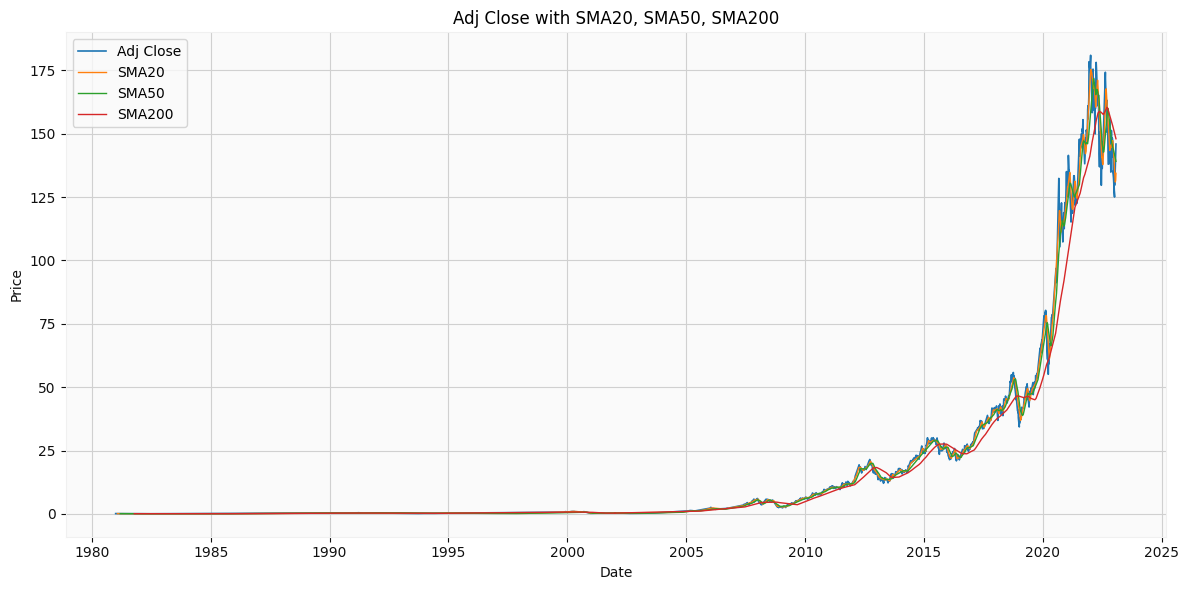

In [ ]:
# Config
price_col = "Adj Close" 
ma_windows = [20, 50, 200]

#  MOVING AVERAGES 
df = ts[[price_col]].copy()
for w in ma_windows:
    df[f"SMA{w}"] = df[price_col].rolling(w).mean()


#QUICK DIAGNOSTICS
latest = df.dropna().iloc[-1]
print("Latest values:")
for w in ma_windows:
    print(f"  {price_col}: {latest[price_col]:.2f} | SMA{w}: {latest[f'SMA{w}']:.2f}")

# % distance from 200D SMA (how stretched price is vs. long-term trend)
if df["SMA200"].notna().any():
    pct_above_200 = (latest[price_col] / latest["SMA200"] - 1) * 100
    print(f"\n% above 200D SMA: {pct_above_200:.2f}%")

# Simple trend label using 50 vs 200
def trend_label(row):
    if np.isnan(row["SMA50"]) or np.isnan(row["SMA200"]): 
        return np.nan
    return "Uptrend" if row["SMA50"] > row["SMA200"] else "Downtrend"

df["Trend"] = df.apply(trend_label, axis=1)
print("\nCurrent trend:", df["Trend"].dropna().iloc[-1])

# ==== CROSSOVER DATES (Golden/Death crosses) ====
cross = np.sign(df["SMA50"] - df["SMA200"]).diff()
golden_crosses = df.index[(cross > 0)]
death_crosses  = df.index[(cross < 0)]

print("\nGolden cross dates (SMA50 crossing above SMA200):")
print(golden_crosses[-5:])  # last 5

print("\nDeath cross dates (SMA50 crossing below SMA200):")
print(death_crosses[-5:])   # last 5

# ==== PLOT ====
plt.figure(figsize=(12,6))
plt.plot(df.index, df[price_col], linewidth=1.2, label=price_col)
for w in ma_windows:
    plt.plot(df.index, df[f"SMA{w}"], linewidth=1.0, label=f"SMA{w}")
plt.title(f"{price_col} with {', '.join(['SMA'+str(w) for w in ma_windows])}")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


# Hypothesis Testing

In [ ]:
import numpy as np
import pandas as pd

price_col = "Adj Close"
price = ts[price_col].astype(float)

# % daily return: (today - yesterday) / yesterday
returns = price.pct_change().dropna()

# (Optional) log returns – often a bit closer to normal
log_returns = np.log(price).diff().dropna()


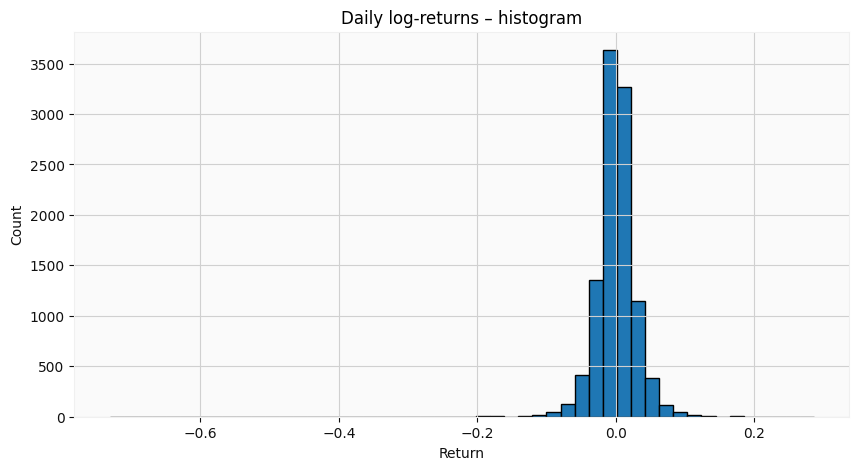

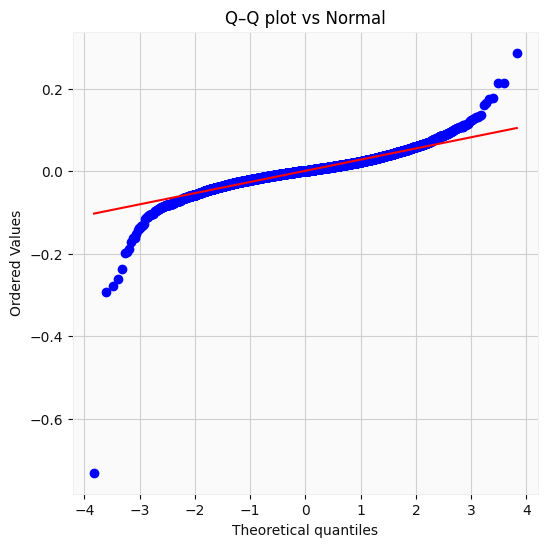

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

data = log_returns   # try returns too; start with log_returns

# Histogram
plt.figure(figsize=(10,5))
plt.hist(data, bins=50, edgecolor="black")
plt.title("Daily log-returns – histogram")
plt.xlabel("Return")
plt.ylabel("Count")
plt.show()

# Q–Q plot (straight line ≈ normal)
plt.figure(figsize=(6,6))
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q–Q plot vs Normal")
plt.show()


In [ ]:
from scipy import stats

alpha = 0.05
x = data.values  # numpy array

# D’Agostino K^2 (good general test)
k2_stat, k2_p = stats.normaltest(x)

# Shapiro–Wilk (good for <= 5000 points; we sample if bigger)
sh_sample = data.sample(min(5000, len(data)), random_state=0).values
sh_stat, sh_p = stats.shapiro(sh_sample)

print("D’Agostino K^2: p =", k2_p, "->", "NOT normal" if k2_p < alpha else "could be normal")
print("Shapiro–Wilk : p =", sh_p,  "->", "NOT normal" if sh_p < alpha else "could be normal")

# Helpful extras
skew = stats.skew(x, bias=False)
kurt_excess = stats.kurtosis(x, fisher=True, bias=False)  # 0 for normal
print(f"\nMean={data.mean():.6f}, Std={data.std(ddof=1):.6f}")
print(f"Skew={skew:.3f} (0 is symmetric), Excess kurtosis={kurt_excess:.3f} (0 is normal)")


D’Agostino K^2: p = 0.0 -> NOT normal
Shapiro–Wilk : p = 1.0119849130968388e-41 -> NOT normal

Mean=0.000670, Std=0.028662
Skew=-1.744 (0 is symmetric), Excess kurtosis=47.017 (0 is normal)
